# MAGMA experimnetations

## Artificial data : Different HP + Common grid

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings

plt.style.use("bmh")
sys.path.append("../src/")
warnings.filterwarnings("ignore")

from kernels import ExponentiatedQuadraticKernel, GaussianKernel
from MAGMA import MAGMA

### Exponentied Quadratic Kernel

In [2]:
N = 100
M = 5

t0 = 0
tN = 10 + 1e-3

common_T = np.linspace(t0, tN, N)
print(common_T.shape)

(100,)


In [3]:
a = np.random.uniform(-2, 2)
b = np.random.uniform(0, 10)

m0 = a * common_T + b
m0_function = lambda t : a * t + b
print(m0.shape)

(100,)


In [4]:
theta0 = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))])
print(theta0)

[73.23333569  3.38767254]


In [5]:
K_theta0 = ExponentiatedQuadraticKernel.compute_all(theta0, common_T)
print(K_theta0.shape)

(100, 100)


In [6]:
mu0 = np.random.multivariate_normal(m0, K_theta0)
print(mu0.shape)

(100,)


In [7]:
Theta = np.array([np.random.uniform(1, np.exp(5), size=M), np.random.uniform(1, np.exp(2), size=M)]).T
Sigma = np.random.uniform(0, 1, size=M)

print(Theta)
print(Sigma)

[[108.13536514   2.0368511 ]
 [122.00115025   5.63163933]
 [146.93941585   3.15900102]
 [ 67.16183042   1.88911763]
 [100.27818708   2.14899144]]
[0.33353849 0.80687341 0.10835363 0.26388686 0.16954169]


In [8]:
Y = np.zeros((M, N))
for i in range(M):
    C_Theta = ExponentiatedQuadraticKernel.compute_all(Theta[i], common_T)
    Psi_Theta_Sigma = C_Theta + Sigma[i] * np.identity(N)
    Yi = np.random.multivariate_normal(mu0, Psi_Theta_Sigma)
    Y[i] = Yi
print(Y.shape)

(5, 100)


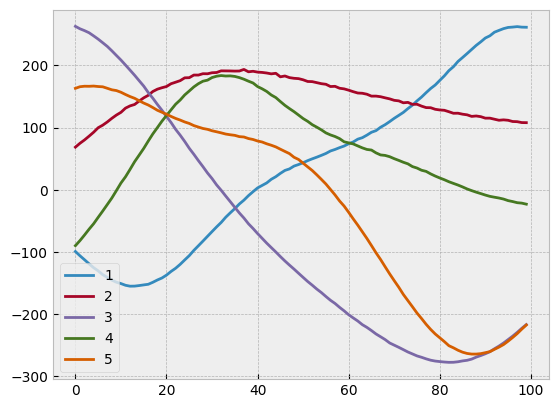

In [9]:
for i in range(M):
    plt.plot(Y[i], label=f"{i + 1}")
plt.legend()
plt.show()

In [10]:
model = MAGMA(
    T=None,
    Y=Y,
    common_T=common_T,
    m0=m0, 
    m0_function=m0_function,
    theta0=np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))]), 
    Theta=np.array([np.random.uniform(1, np.exp(5), size=M), np.random.uniform(1, np.exp(2), size=M)]).T, 
    Sigma=np.random.uniform(0, 1, size=M),
    common_hp_flag=False,
    common_grid_flag=True,
    save_history_flag=True,
    scipy_optimize_display=True,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

In [11]:
model.fit(max_iterations=1, eps=-np.inf)

MAGMA Training:   0%|          | 0/1 [00:00<?, ?it/s]

theta0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39298D+03    |proj g|=  5.11146D+03

At iterate    1    f=  3.39219D+03    |proj g|=  5.11067D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


In [ ]:
model.scipy_optimize_display = False
model.fit(max_iterations=49, eps=-np.inf)

In [ ]:
history = model.history
len(history)

57

In [ ]:
LL_theta0 = []
LL_Theta_Sigma = []

for epoch_history in history[1:]:
    LL_theta0.append(epoch_history["LL_theta0"])
    LL_Theta_Sigma.append(epoch_history["LL_Theta_Sigma"])

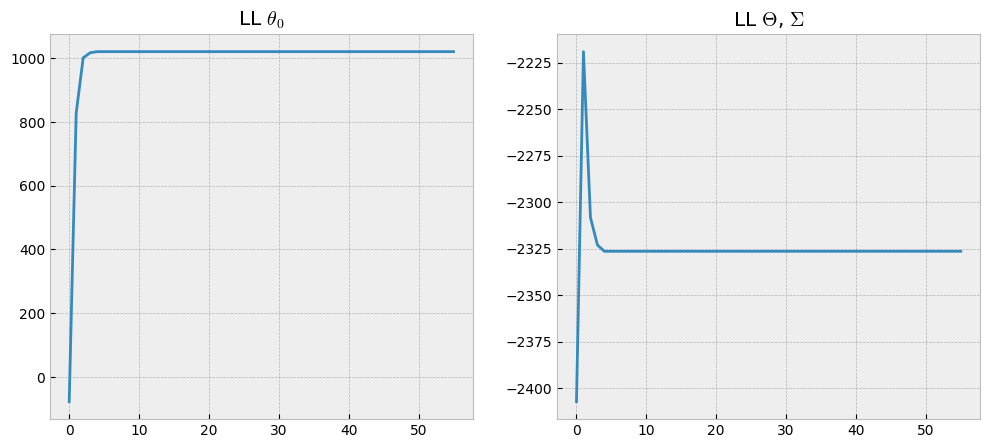

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(LL_theta0)
plt.title("LL $\\theta_0$")
plt.subplot(1, 2, 2)
plt.plot(LL_Theta_Sigma)
plt.title("LL $\Theta$, $\Sigma$")
plt.show()

In [ ]:
Sigma = []
for epoch_history in history:
    Sigma.append(epoch_history["Sigma"])
Sigma = np.array(Sigma)
print(model.Sigma)

[ 7.48921936  0.79004772 45.5606797   2.34581866  0.10051745]


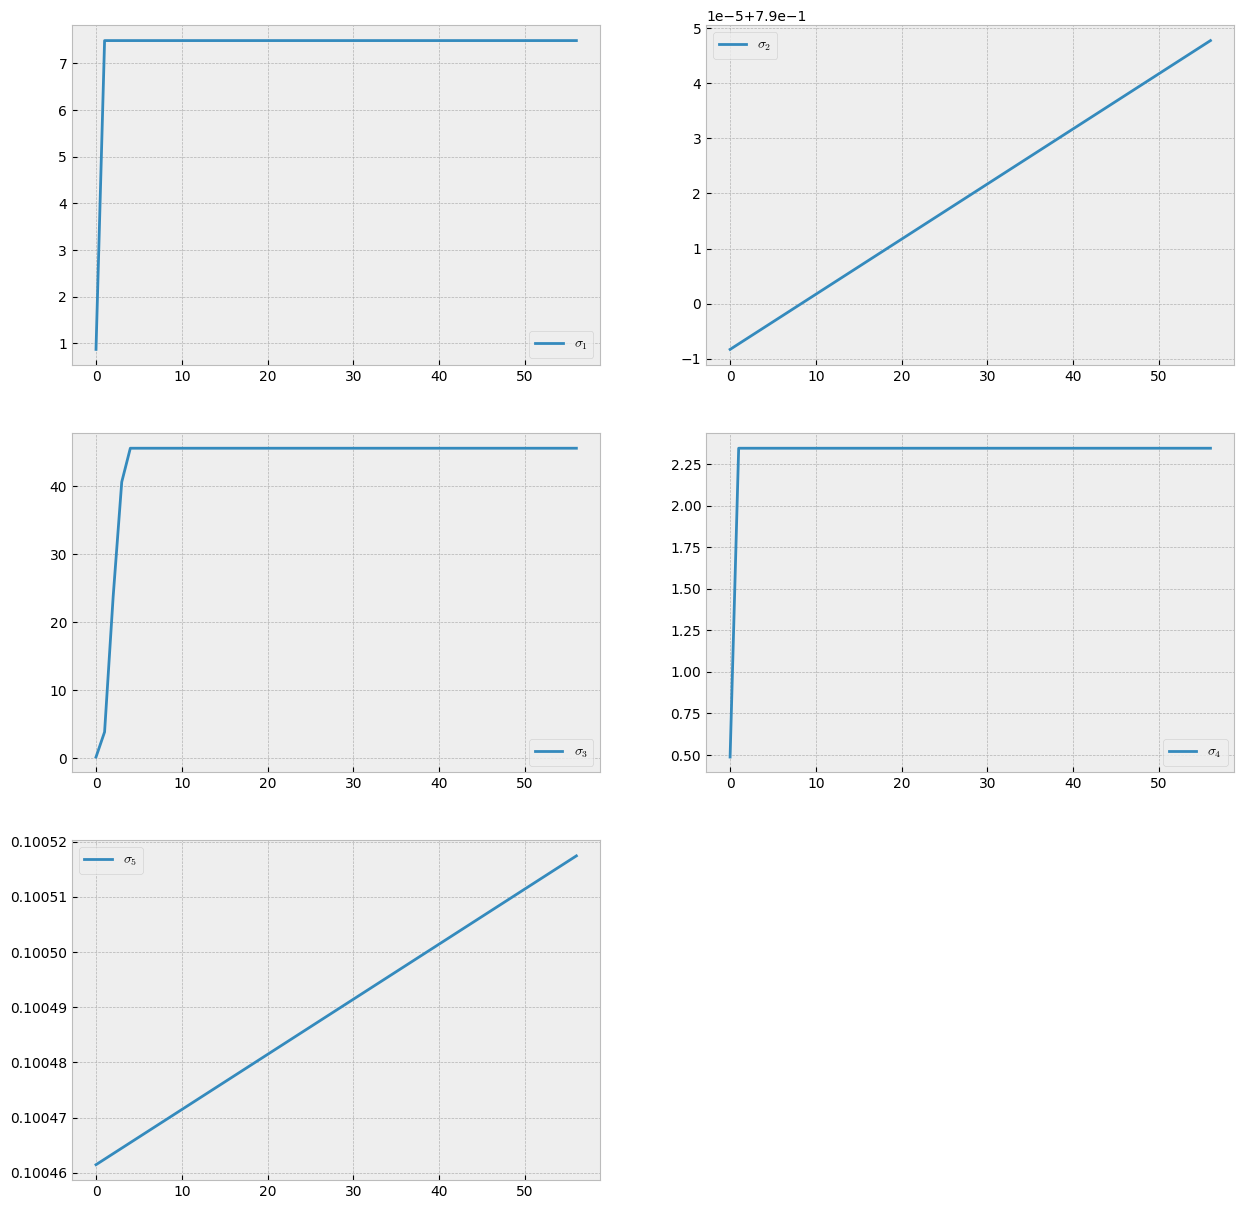

In [ ]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.plot(Sigma[:, i - 1], label=f"$\sigma_{i}$")
    plt.legend()
plt.show()

In [ ]:
m0_estim_norms = []
for epoch_history in history[1:]:
    m0_estim_norms.append(np.linalg.norm(epoch_history["m0"]))

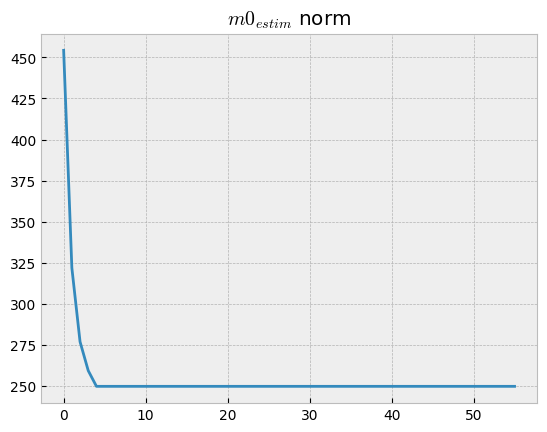

In [ ]:
plt.plot(m0_estim_norms)
plt.title("$m0_{estim}$ norm")
plt.show()

In [ ]:
theta0 = []
for epoch_history in history:
    theta0.append(epoch_history["theta0"])
theta0 = np.array(theta0)
print(model.theta0)

[15.68413778  4.24021351]


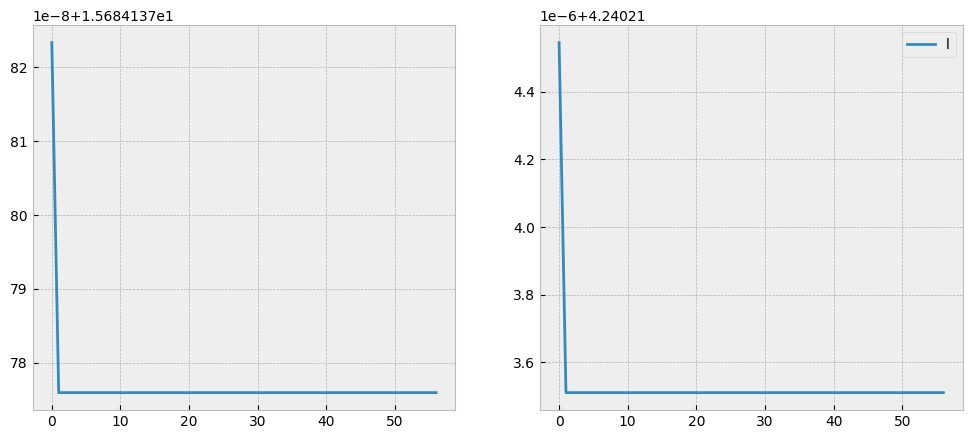

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(theta0[:, 0], label="v")
plt.subplot(1, 2, 2)
plt.plot(theta0[:, 1], label="l")
plt.legend()
plt.show()

In [ ]:
Theta = []
for epoch_history in history:
    Theta.append(epoch_history["Theta"])
Theta = np.array(Theta)
print(Theta.shape)
print(model.Theta)

(57, 5, 2)
[[57.79367099  5.23686913]
 [79.23579798  1.92683036]
 [89.75011057 12.0788278 ]
 [21.21507053  4.34587845]
 [40.70543084  1.95713723]]


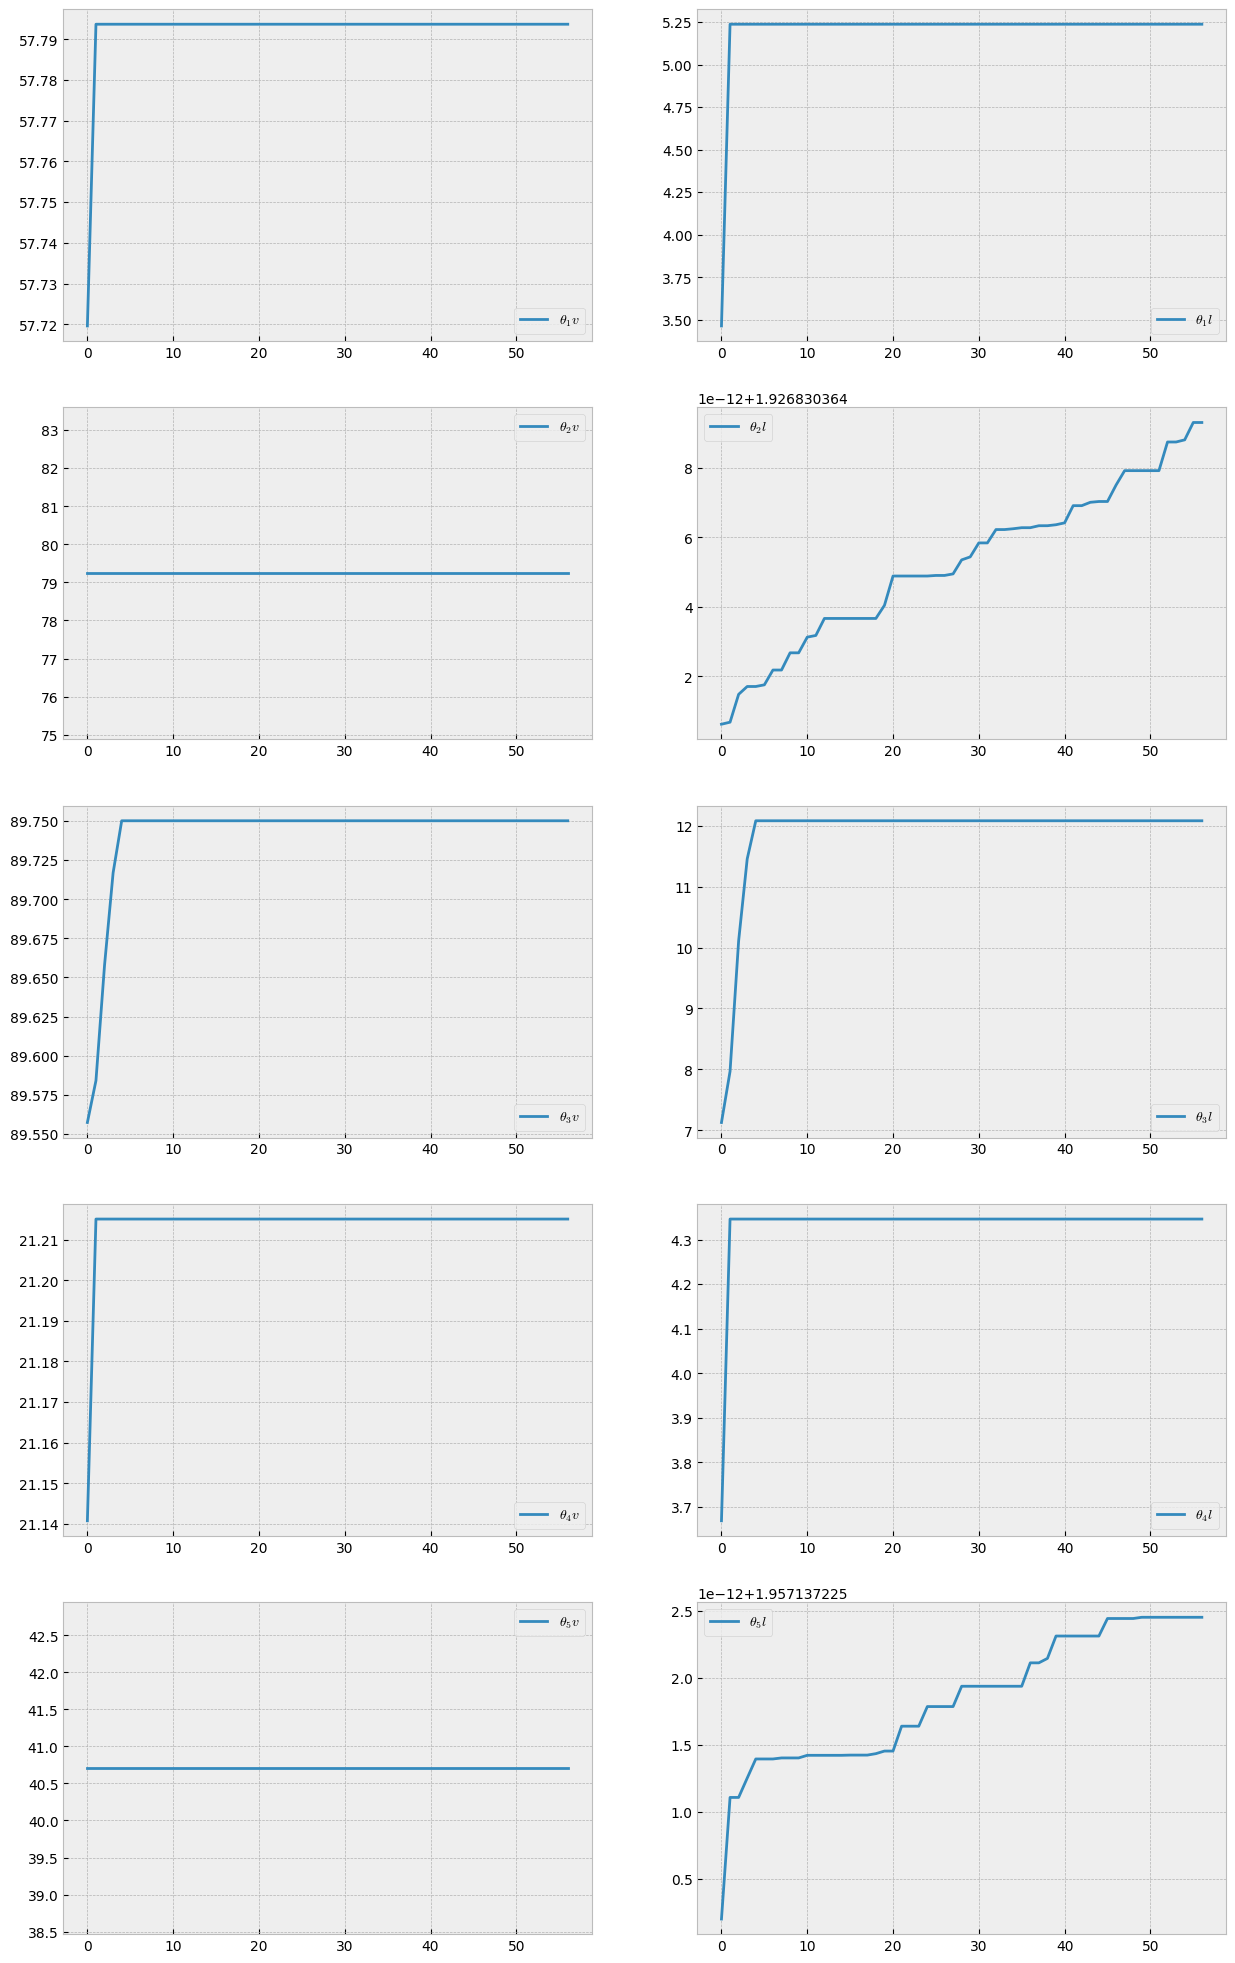

In [ ]:
plt.figure(figsize=(15, M * 5))
cpt = 0
for i in range(1, M + 1):
    cpt += 1
    plt.subplot(M, 2, cpt)
    plt.plot(Theta[:, i - 1, 0], label=f"$\\theta_{i} v$")
    plt.legend()
    cpt += 1
    plt.subplot(M, 2, cpt)
    plt.plot(Theta[:, i - 1, 1], label=f"$\\theta_{i} l$")
    plt.legend()
plt.show()